In [ ]:
!pip install lightgbm catboost
!pip install pandas==1.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 19.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.


In [ ]:
import pandas as pd
import random


In [ ]:
random.seed(108)

In [ ]:
'''
  Checks if everything works as intended. Must be run so that we can use row_1 for predictions
'''
import numpy as np
import random
import pandas as pd
import joblib
import copy
model=joblib.load('GradientBoost_model.sav')
df=pd.read_csv('X_train_ordered.csv')
X=df.drop(columns=['Player Name','Team','pid','role','bid team','output','fair'])

row_1=dict(X.iloc[0])
row_1_pred=pd.DataFrame()
row_1_pred=row_1_pred.append(row_1,ignore_index=True)
print(model.predict_proba(row_1_pred))
print(model.predict(row_1_pred))

[[0.85322136 0.14677864]]
[0]


<ipython-input-5-5c4ace7d126c>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  row_1_pred=row_1_pred.append(row_1,ignore_index=True)


Defines required functions

In [ ]:

names=['Chennai Super Kings', 'Delhi Capitals', 'Gujrat Titans', 'Kolkata Knight Riders', 'Lucknow Super Giants' ,'Mumbai Indians', 'Punjab Kings', 'Rajastan Royals' ,'Royal Challengers Banglore', 'Sunrisers Hyderabad']
max_batsmans=[]
max_bowlers=[]
max_allrounders=[]
max_wicketkeepers=[]
old_df=pd.read_csv('player_list_in_order_stats_2022_corrected.csv')
new_df=pd.read_csv('player_list_in_order_stats_2023_corrected.csv')

for j in range(10):

  last=dict(old_df.iloc[270])
#  last=dict(new_df.iloc[139])
  max_batsmans.append(last[names[j]+' ba'])
  max_bowlers.append(last[names[j]+' bo'])
  max_allrounders.append(last[names[j]+' ar'])
  max_wicketkeepers.append(last[names[j]+' wk'])

purse=[]
batsman=[]
bowlers=[]
allrounders=[]
wicketkeepers=[]
overseas=[]

for j in range(10):
  first=dict(new_df.iloc[0])
  batsman.append(first[names[j]+' ba'])
  bowlers.append(first[names[j]+' bo'])
  allrounders.append(first[names[j]+' ar'])
  wicketkeepers.append(first[names[j]+' wk'])
  overseas.append(first[names[j]+' os'])
  purse.append(first[names[j]+' purse'])

teams={}
teams['purse']=np.array(purse)
teams['demand ba']=np.array(max_batsmans)-np.array(batsman)
teams['demand bo']=np.array(max_bowlers)-np.array(bowlers)
teams['demand ar']=np.array(max_allrounders)-np.array(allrounders)
teams['demand wk']=np.array(max_wicketkeepers)-np.array(wicketkeepers)
teams['os']=np.array(overseas)

def buy(player_info,player_price,all_teams,team_id):
  rol=player_info['role']
  isos=player_info['isoversea']
  all_teams_copy=copy.deepcopy(all_teams)
  purses=copy.deepcopy(all_teams['purse'])
  demands=copy.deepcopy(all_teams['demand '+rol])
  overseas=copy.deepcopy(all_teams['os'])
  demands[team_id]-=1
  purses[team_id]-=player_price
  all_teams_copy['demand '+rol]=demands
  all_teams_copy['purse']=purses
  if isos==1:
    overseas[team_id]+=1
    all_teams_copy['os']=overseas
  return all_teams_copy

def should_bid(player_info,player_price,all_teams,team_id,is_special):
  player_i=copy.deepcopy(player_info)
  rol=player_i['role']
  del player_i['Player Name']
  del player_i['pid']
  del player_i['role']
  del player_i['Team']
  del player_i['fair']
  #del player_i['bid team']
  #del player_i['output']
  player_i['Price']=player_price
  player_i['no overseas']=all_teams['os'][team_id]
  purses=copy.deepcopy(all_teams['purse'])
  demands=copy.deepcopy(all_teams['demand '+rol])
  if purses[team_id]<player_price:
    return False
  if player_i['no overseas']==8 and player_i['isoversea']==1:
    return False
  if player_price+(all_teams['demand ba'][team_id]+all_teams['demand bo'][team_id]+all_teams['demand wk'][team_id]+all_teams['demand ar'][team_id]-1)*0.2>purses[team_id]:
    return False


  player_i['demand_team']=demands[team_id]
  player_i['demand_other']=np.sum(demands)-demands[team_id]
  player_i['purse bid']=purses[team_id]
  maxx_purse=0.0
  sum_purse=0.0
  for p in range(len(purses)):
    if p!=team_id:
      sum_purse+=purses[p]
      if maxx_purse<purses[p]:
        maxx_purse=purses[p]
  player_i['max purse']=maxx_purse
  player_i['avg purse']=(sum_purse-maxx_purse)/8.0


  row_1_pred=pd.DataFrame()
  row_1_pred=row_1_pred.append(row_1,ignore_index=True)
  row_1_pred=row_1_pred.append(player_i,ignore_index=True)
  probab_of_1=model.predict_proba(row_1_pred)[1][1]
  if is_special:#incorporating perception module
    probab_of_1 = 1.0 - (1.0-probab_of_1)**2
  if probab_of_1>=0.5:
    return True
  else:
    return False









Simulates the auction

In [ ]:
path='X_test_ordered_2023.csv'
#special_players=[184,535,161,198,167]
#special_players=[184,535,161,167]
special_players=[184,535,161]
auction_players=pd.read_csv(path)
auction_players=auction_players.drop(columns=['bid team','no overseas','demand_team','demand_other','purse bid','max purse','avg purse','output'])
auction_results=pd.DataFrame()
y_fair=[]
for i in range(0,len(auction_players),10):
  player=auction_players.iloc[i]
  y_fair.append(player['fair'])
  pprice=player['base']
  bidding_teams=[]
  special=False
  if player['pid'] in special_players:
    special=True
  for z in range(10):
    if should_bid(player,pprice,teams,z,is_special=special):
      bidding_teams.append(z)

  if len(bidding_teams)==0:

    player['Sold Team']='Unsold'
    player['Sold Price']=0.0

    auction_results=auction_results.append(player,ignore_index=True)
  elif len(bidding_teams)==1:
    purses=copy.deepcopy(teams['purse'])
    demands=copy.deepcopy(teams['demand '+player['role']])
    player['Sold Team']=names[bidding_teams[0]]
    player['demand_team']=demands[bidding_teams[0]]
    player['demand_other']=np.sum(demands)-demands[bidding_teams[0]]
    player['purse bid']=purses[bidding_teams[0]]
    maxx_purse=0.0
    sum_purse=0.0
    for p in range(len(purses)):
      if p!=bidding_teams[0]:
        sum_purse+=purses[p]
        if maxx_purse<purses[p]:
          maxx_purse=purses[p]
    player['max purse']=maxx_purse
    player['avg purse']=(sum_purse-maxx_purse)/8.0
    player['Sold Price']=pprice
    auction_results=auction_results.append(player,ignore_index=True)
    teams=buy(player,pprice,teams,bidding_teams[0])
  else:
    if pprice<1:
      pprice+=0.05
    elif pprice<2:
      pprice+=0.1
    else:
      pprice+=0.2
  while len(bidding_teams)>=2:
    new_bidding_teams=[]
    for z in bidding_teams:
      if should_bid(player,pprice,teams,z,is_special=special):
        new_bidding_teams.append(z)

    #bidding_teams=new_bidding_teams
    if len(new_bidding_teams)==1:

      purses=copy.deepcopy(teams['purse'])
      demands=copy.deepcopy(teams['demand '+player['role']])
      player['Sold Team']=names[bidding_teams[0]]
      player['demand_team']=demands[bidding_teams[0]]
      player['demand_other']=np.sum(demands)-demands[bidding_teams[0]]
      player['purse bid']=purses[bidding_teams[0]]
      maxx_purse=0.0
      sum_purse=0.0
      for p in range(len(purses)):
        if p!=bidding_teams[0]:
          sum_purse+=purses[p]
        if maxx_purse<purses[p]:
          maxx_purse=purses[p]
      player['max purse']=maxx_purse
      player['avg purse']=(sum_purse-maxx_purse)/8.0
      player['Sold Price']=pprice
      auction_results=auction_results.append(player,ignore_index=True)
      teams=buy(player,pprice,teams,new_bidding_teams[0])
    elif len(new_bidding_teams)==0:
      rando=random.choice(bidding_teams)
      player['Sold Team']=names[rando]
      player['Sold Price']=pprice
      auction_results=auction_results.append(player,ignore_index=True)
      teams=buy(player,pprice,teams,rando)

    bidding_teams=new_bidding_teams
    if pprice<1:
      pprice+=0.05
    elif pprice<2:
      pprice+=0.1
    else:
      pprice+=0.2

Streaming output truncated to the last 5000 lines.
<ipython-input-6-0f0db0e82c81>:96: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  row_1_pred=row_1_pred.append(player_i,ignore_index=True)
<ipython-input-7-c0bacf633519>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player['Sold Team']='Unsold'
<ipython-input-7-c0bacf633519>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player['Sold Team']='Unsold'
<ipython-input-7-c0bacf633519>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

S

In [ ]:
auction_results.head()

,Player Name,Team,Price,pid,isbatsman,isbowler,iswicketkeeper,isoversea,isCap,role,...,bowl_death,fair,supply,Sold Team,demand_team,demand_other,purse bid,max purse,avg purse,Sold Price
0,Kane Williamson,Gujrat Titans,2.00,78,1,0,0,1,1,ba,...,0.0,6.982500,0,Kolkata Knight Riders,3.0,-3.0,7.05,42.25,19.65,3.8
1,Harry Brook,Sunrisers Hyderabad,13.25,1211,1,0,0,1,1,ba,...,0.0,4.390500,1,Kolkata Knight Riders,3.0,-4.0,7.05,38.45,19.65,3.8
2,Mayank Agarwal,Sunrisers Hyderabad,8.25,167,1,0,0,0,1,ba,...,0.0,3.104083,4,Kolkata Knight Riders,3.0,-5.0,7.05,34.65,19.65,1.0
3,Ajinkya Rahane,Chennai Super Kings,0.50,187,1,0,0,0,1,ba,...,0.0,0.948500,7,Unsold,NaN,NaN,NaN,NaN,NaN,0.0
4,Joe Root,Rajastan Royals,1.00,382,1,0,0,1,1,ba,...,9.0,2.803167,4,Kolkata Knight Riders,2.0,-5.0,6.05,34.65,19.65,1.0


In [ ]:
auction_results.to_csv('auction results.csv',index=False)

Accuracy

In [ ]:
len(auction_results[(auction_results['Team']==auction_results['Sold Team'])])/len(auction_results)

0.4

Compare Mean error

In [ ]:
import sklearn
y_true=auction_results['Price']
y_pred=auction_results['Sold Price']
print(sklearn.metrics.mean_absolute_error(y_true,y_pred))
print(sklearn.metrics.mean_absolute_error(y_true,y_fair))

0.9182142857142854
1.7709826498114978


Compare r2 score

In [ ]:
print(sklearn.metrics.r2_score(y_true,y_pred))
print(sklearn.metrics.r2_score(y_true,y_fair))

0.5090472379567215
0.12074703092232952


Compare plots

(-10.0, 10.0)

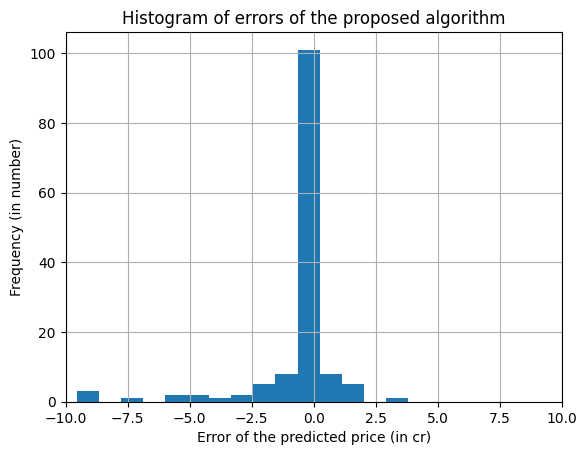

In [ ]:
import matplotlib.pyplot as plt
plt.grid('on')
plt.xlabel('Error of the predicted price (in cr)')
plt.ylabel('Frequency (in number)')
plt.title('Histogram of errors of the proposed algorithm')
plt.hist(y_pred-y_true,bins=20)
plt.xlim(-10,10)

(-10.0, 10.0)

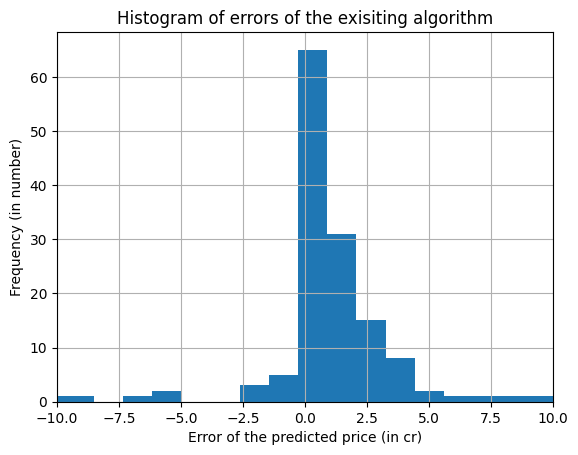

In [ ]:
plt.grid('on')
plt.xlabel('Error of the predicted price (in cr)')
plt.ylabel('Frequency (in number)')
plt.title('Histogram of errors of the exisiting algorithm')
plt.hist(y_fair-y_true,bins=20)
plt.xlim(-10,10)

best performance given by gradient boost.